C:\Users\sarat\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | beta=0.00 | Loss:184.36  Recon:184.36  KL:150.12
Epoch 02 | beta=0.10 | Loss:73.35  Recon:66.99  KL:63.60
Epoch 03 | beta=0.20 | Loss:62.31  Recon:52.70  KL:48.03
Epoch 04 | beta=0.30 | Loss:61.27  Recon:48.93  KL:41.14
Epoch 05 | beta=0.40 | Loss:62.12  Recon:47.30  KL:37.05
Epoch 06 | beta=0.50 | Loss:64.01  Recon:47.07  KL:33.88
Epoch 07 | beta=0.60 | Loss:66.94  Recon:48.43  KL:30.84
Epoch 08 | beta=0.70 | Loss:69.30  Recon:49.44  KL:28.37
Epoch 09 | beta=0.80 | Loss:71.62  Recon:50.64  KL:26.23
Epoch 10 | beta=0.90 | Loss:73.93  Recon:52.02  KL:24.35
Epoch 11 | beta=1.00 | Loss:75.97  Recon:53.30  KL:22.68
Epoch 12 | beta=1.00 | Loss:75.73  Recon:53.25  KL:22.48
Epoch 13 | beta=1.00 | Loss:75.42  Recon:52.92  KL:22.50
Epoch 14 | beta=1.00 | Loss:75.26  Recon:52.82  KL:22.44
Epoch 15 | beta=1.00 | Loss:75.05  Recon:52.65  KL:22.39
Epoch 16 | beta=1.00 | Loss:74.98  Recon:52.63  KL:22.35
Epoch 17 | beta=1.00 | Loss:74.89  Recon:52.49  KL:22.40
Epoch 18 | beta=1.00 | Loss:

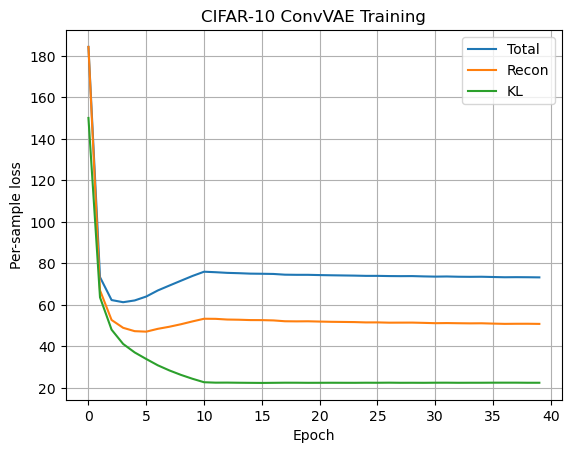

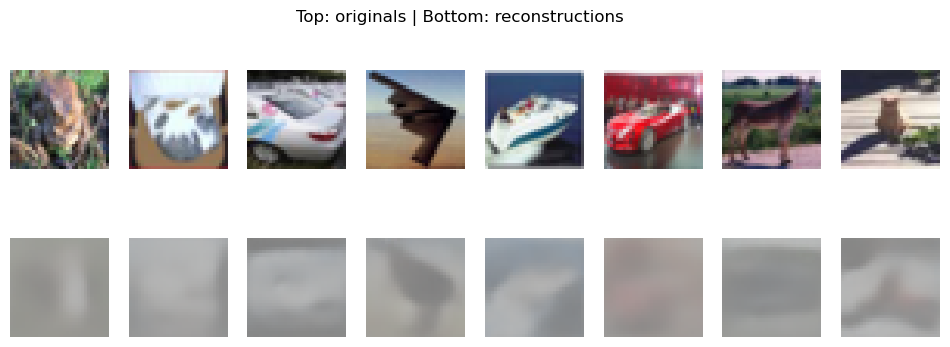

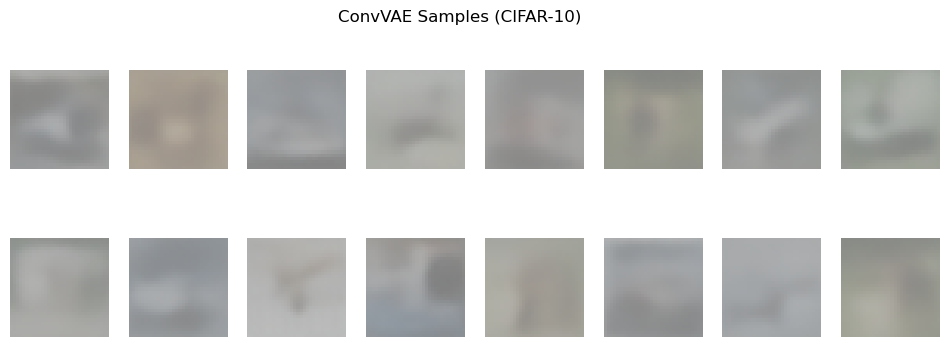

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------
# Data: CIFAR-10 (3x32x32)
# ----------------------------
transform = transforms.ToTensor()  # keep [0,1]
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# ----------------------------
# Model: ConvVAE (Gaussian dec)
# ----------------------------
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # in: (B,3,32,32)
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),     # 32 -> 16
            nn.Conv2d(64,128,4, 2, 1), nn.ReLU(),     # 16 -> 8
            nn.Conv2d(128,256,4,2,1), nn.ReLU(),      # 8 -> 4
            nn.Conv2d(256,256,3,1,1), nn.ReLU(),      # 4 -> 4
        )
        self.flatten = nn.Flatten()
        self.fc_mu     = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

    def forward(self, x):
        h = self.net(x)
        h = self.flatten(h)
        return self.fc_mu(h), self.fc_logvar(h)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256,256,3,1,1), nn.ReLU(),  # 4 -> 4
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(),  # 4 -> 8
            nn.ConvTranspose2d(128, 64,4,2,1), nn.ReLU(),  # 8 -> 16
            nn.ConvTranspose2d( 64, 32,4,2,1), nn.ReLU(),  # 16 -> 32
            nn.Conv2d(32, 3, 3, 1, 1)  # output logits for Gaussian mean; we'll use sigmoid for viewing
        )

    def forward(self, z):
        h = self.fc(z).view(-1,256,4,4)
        logits = self.net(h)  # treat as predicted mean (pre-sigmoid for viewing)
        return logits

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        pred = self.decoder(z)  # predicted mean (logits); we'll use MSE against x
        return pred, mu, logvar

# ----------------------------
# Loss: MSE + beta * KL
# ----------------------------
def vae_loss_mse(pred, x, mu, logvar, beta=1.0):
    # MSE as Gaussian negative log-likelihood (sigma^2 = 1)
    recon = F.mse_loss(pred, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta*kl, recon, kl

# ----------------------------
# Train
# ----------------------------
epochs = 40
latent_dim = 64
model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

beta_start, beta_end = 0.0, 1.0
warmup_epochs = 10

train_losses, recon_losses, kl_losses = [], [], []

model.train()
for epoch in range(epochs):
    beta = beta_start + (beta_end - beta_start) * min(1.0, epoch / warmup_epochs)
    total, tot_recon, tot_kl = 0.0, 0.0, 0.0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        pred, mu, logvar = model(x)
        loss, r, k = vae_loss_mse(pred, x, mu, logvar, beta=beta)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
        tot_recon += r.item()
        tot_kl += k.item()

    N = len(train_loader.dataset)
    train_losses.append(total/N)
    recon_losses.append(tot_recon/N)
    kl_losses.append(tot_kl/N)

    print(f"Epoch {epoch+1:02d} | beta={beta:.2f} | "
          f"Loss:{total/N:.2f}  Recon:{tot_recon/N:.2f}  KL:{tot_kl/N:.2f}")

# ----------------------------
# Plot losses
# ----------------------------
plt.figure(); plt.plot(train_losses, label='Total'); plt.plot(recon_losses, label='Recon'); plt.plot(kl_losses, label='KL')
plt.title("CIFAR-10 ConvVAE Training"); plt.xlabel("Epoch"); plt.ylabel("Per-sample loss"); plt.grid(True); plt.legend(); plt.show()

# ----------------------------
# Reconstructions
# ----------------------------
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x[:8].to(device)
    pred, _, _ = model(x)
    view = torch.sigmoid(pred).clamp(0,1).cpu()  # just for nicer viewing

fig, axs = plt.subplots(2, 8, figsize=(12, 4))
for i in range(8):
    axs[0,i].imshow(x[i].permute(1,2,0).cpu()); axs[0,i].axis('off')
    axs[1,i].imshow(view[i].permute(1,2,0));    axs[1,i].axis('off')
plt.suptitle("Top: originals | Bottom: reconstructions"); plt.show()

# ----------------------------
# Sampling
# ----------------------------
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    logits = model.decoder(z)
    samples = torch.sigmoid(logits).clamp(0,1).cpu()

fig, axes = plt.subplots(2, 8, figsize=(12,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].permute(1,2,0))
    ax.axis('off')
plt.suptitle("ConvVAE Samples (CIFAR-10)"); plt.show()
